First, we make sure that the Colab runtime type is Python 3 with GPU. Then we download the dataset to Colab.

In [0]:
!wget https://github.com/CoserU/coseru.github.io/raw/master/ASLtest/dataset_ASL.zip

--2019-04-19 02:04:53--  https://github.com/CoserU/coseru.github.io/raw/master/ASLtest/dataset_ASL.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CoserU/coseru.github.io/master/ASLtest/dataset_ASL.zip [following]
--2019-04-19 02:04:53--  https://raw.githubusercontent.com/CoserU/coseru.github.io/master/ASLtest/dataset_ASL.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92794349 (88M) [application/zip]
Saving to: ‘dataset_ASL.zip’

dataset_ASL.zip     100%[===================>]  88.50M   154MB/s    in 0.6s    

2019-04-19 02:04:54 (154 MB/s) - ‘dataset_ASL.zip’ saved [92794

In [0]:
!unzip -q dataset_ASL.zip

# Preparing the Data

Import tensorflow, Keras layers and other packages.

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, DepthwiseConv2D, Flatten, BatchNormalization, ReLU, AveragePooling2D, Add

import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Now let’s take a look at the images. They are of different sizes and different aspect ratios.

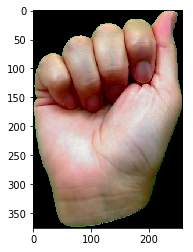

In [0]:
# Training directory and validation directory
train_path = 'dataset_ASL/train/'
valid_path = 'dataset_ASL/validation/'

def show_image_from_path(data_path, alphabet):
    folder_path = os.path.join(data_path, alphabet)
    img_files = os.listdir(folder_path)
    img_file = img_files[np.random.choice(len(img_files), 1)[0]]
    img = plt.imread(os.path.join(folder_path, img_file))
    plt.imshow(img)
    
# Show a image randomly picked with label 'a'
show_image_from_path(train_path, 'a')

There are 24 fingerspelled alphabets in the dataset. We need to convert the alphabetical labels to integer labels for model training.

In [0]:
# Alphabet to integer
alphabet2int = {}
for i, char in enumerate('abcdefghiklmnopqrstuvwxy'):
    alphabet2int[char] = i
print(alphabet2int)

# Integer to alphabet
int2alphabet = {val: key for key, val in alphabet2int.items()}
print(int2alphabet)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}


Here, we will use the `tf.data` API to preprocess the images and build the training/validation datasets. First we get the paths for all images and the corresponding integer labels.

In [0]:
# Get the image paths and the corresponding integer labels
def get_paths_labels(data_path):
    paths = []
    labels = []
    for class_folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, class_folder)
        label = alphabet2int[class_folder]
        for img_path in os.listdir(folder_path):
            paths.append(os.path.join(folder_path, img_path))
            labels.append(label)
    return np.array(paths), np.array(labels)

train_paths, train_labels = get_paths_labels(train_path)
valid_paths, valid_labels = get_paths_labels(valid_path)

Then we randomly shuffle the training paths/labels and validation paths/labels.

In [0]:
# Shuffle the paths/labels
p = np.random.permutation(len(train_labels))
train_paths, train_labels = train_paths[p], train_labels[p]

p = np.random.permutation(len(valid_labels))
valid_paths, valid_labels = valid_paths[p], valid_labels[p]

n_train, n_valid = len(train_labels), len(valid_labels)
print('The size of the training set is {}'.format(n_train)) # 2400 images
print('The size of the validation set is {}'.format(n_valid)) # 600 images

The size of the training set is 2400
The size of the validation set is 600


Here we set the size of the input image as 224*224 for MobileNetV2. For simplicity, we assume the image mean is 0.5 for preprocessing and use 32 as the batch size for both training and validation.

In [0]:
image_size = 224
RGB_mean = np.array([0.5, 0.5, 0.5])
BATCH_SIZE = 32

#Training Dataset

Preprocessing steps for training:

* Decode the png-encoded image.
* Resize the image to 256*256 with padding to keep the same aspect ratio.
* Randomly crop the image to 224*224. The camera sometimes cannot capture the whole gesture, so this data augmentation method lets our model to learn to predict without a complete gesture.
* Randomly flip the image horizontally to learn both right-handed and left-handed gestures.
* Normalize the image tensor.

In [0]:
# Load and preprocess the images for the training dataset
def preprocess_train_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize_image_with_pad(image, 256, 256)
    image = tf.image.random_crop(image, [image_size, image_size, 3])
    image = tf.image.random_flip_left_right(image)
    image /= 255.0
    image -= RGB_mean
    return image

def load_and_preprocess_train_image(path):
    image = tf.read_file(path)
    return preprocess_train_image(image)

train_path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_image_ds = train_path_ds.map(load_and_preprocess_train_image)
train_label_ds = tf.data.Dataset.from_tensor_slices(train_labels)

# Zip the images and labels together
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))

Instructions for updating:
Colocations handled automatically by placer.


Then we set the buffer size and the batch size for training.

In [0]:
# Prepare for training
tr_ds = train_image_label_ds.repeat()
tr_ds = tr_ds.shuffle(buffer_size=1000)
tr_ds = tr_ds.batch(BATCH_SIZE)
tr_ds = tr_ds.prefetch(1)

#Validation Dataset

Preprocessing steps for validation:

* Decode the png-encoded image.
* Resize the image to 224*224 with padding to keep the same aspect ratio.
* Normalize the image tensor.

In [0]:
# Load and preprocess the images for the validation dataset
def preprocess_test_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize_image_with_pad(image, image_size, image_size)
    image /= 255.0
    image -= RGB_mean
    return image

def load_and_preprocess_test_image(path):
    image = tf.read_file(path)
    return preprocess_test_image(image)

valid_path_ds = tf.data.Dataset.from_tensor_slices(valid_paths)
valid_image_ds = valid_path_ds.map(load_and_preprocess_test_image)
valid_label_ds = tf.data.Dataset.from_tensor_slices(valid_labels)

# Zip the images and labels together
valid_image_label_ds = tf.data.Dataset.zip((valid_image_ds, valid_label_ds))

Then we set the buffer size and the batch size for validation.

In [0]:
# Prepare for validation
va_ds = valid_image_label_ds.repeat()
va_ds = va_ds.shuffle(buffer_size=1000)
va_ds = va_ds.batch(BATCH_SIZE)
va_ds = va_ds.prefetch(1)

#MobileNetV2

In this tutorial, we will use Keras functional API to implement MobileNetV2 as our model (just for fun!) However, if you are interested in transfer learning, you can download a pre-trained MobileNetV2 directly from [Keras applications](https://keras.io/applications/#mobilenetv2) instead of writing the model from scratch.

In [0]:
def ConvBNReLU(inputs, o, kernel_size=3, strides=1, dwise=False, bn=True, relu=True):
    padding = 'same'
    if dwise:
        x = DepthwiseConv2D(kernel_size=kernel_size, padding=padding, strides=strides, use_bias=not bn)(inputs)
    else:
        x = Conv2D(o, kernel_size=kernel_size, padding=padding, strides=strides, use_bias=not bn)(inputs)

    if bn:
        x = BatchNormalization()(x)

    if relu:
        x = ReLU()(x)

    return x


def BottleNeck(inputs, i, o, expansion, strides):
    add_residual = strides == 1 and i == o
    x = ConvBNReLU(inputs, i*expansion, kernel_size=1)
    x = ConvBNReLU(x, i*expansion, strides=strides, dwise=True)
    x = ConvBNReLU(x, o, kernel_size=1, relu=False)
    
    if add_residual:
        x = Add()([x, inputs])

    return x


def MobileNetV2(inputs, n_classes, width_multiplier=1.):
    bottleneck_params = [
        # t, c, n, s
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
    ]

    input_channel = int(32*width_multiplier)
    for param in bottleneck_params:
        param[1] = int(param[1]*width_multiplier)

    x = ConvBNReLU(inputs, input_channel, strides=2)

    for (t, c, n, s) in bottleneck_params:
        x = BottleNeck(x, input_channel, c, t, s)
        for _ in range(n-1):
            x = BottleNeck(x, c, c, t, 1)
        input_channel = c

    x = ConvBNReLU(x, int(1280*width_multiplier), kernel_size=1)
    x = AveragePooling2D(pool_size=7, padding='same')(x)
    x = Flatten()(x)
    out = Dense(n_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=out)

The model will take inputs of the shape [N, 224, 224, 3] and outputs probabilities of the shape [N, 24], where N is the batch size.

In [0]:
model = MobileNetV2(Input(shape=(image_size,image_size,3)), len(alphabet2int))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#Training the Model

We compile the model with `Adam` optimizer with 0.001 learning rate and `sparse_catergorical_crossentropy` loss. The model will be saved after every epoch via `tf.keras.callbacks.ModelCheckpoint`.

In [0]:
# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
!mkdir training_checkpoints

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.hdf5")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix)

Let’s say we would like to train the model for 30 epochs. Each epoch takes around 30 seconds with GPU on Colab, so 30 epochs only take 15 to 20 minutes in total. We should notice that the batch size is 32 here.

In [0]:
epochs = 30
steps_per_epoch = n_train // BATCH_SIZE if n_train % BATCH_SIZE == 0 else n_train // BATCH_SIZE + 1 # 75 steps
validation_steps = n_valid // BATCH_SIZE if n_valid % BATCH_SIZE == 0 else n_valid // BATCH_SIZE + 1 # 19 steps

Below are the codes for model training using Keras Model `fit` method.

In [0]:
model_histroy = model.fit(
    tr_ds.make_one_shot_iterator(),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=va_ds.make_one_shot_iterator(),
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
)

Epoch 1/30
75/75 [==============================] - 67s 892ms/step - loss: 2.8416 - acc: 0.1354 - val_loss: 3.3145 - val_acc: 0.0395
Epoch 2/30
75/75 [==============================] - 23s 309ms/step - loss: 2.0638 - acc: 0.3058 - val_loss: 3.4940 - val_acc: 0.0461
Epoch 3/30
75/75 [==============================] - 23s 308ms/step - loss: 1.5574 - acc: 0.4683 - val_loss: 4.3750 - val_acc: 0.0428
Epoch 4/30
75/75 [==============================] - 23s 311ms/step - loss: 1.1224 - acc: 0.6196 - val_loss: 4.7229 - val_acc: 0.0395
Epoch 5/30
75/75 [==============================] - 24s 316ms/step - loss: 0.9008 - acc: 0.7008 - val_loss: 6.0347 - val_acc: 0.0395
Epoch 6/30
75/75 [==============================] - 23s 312ms/step - loss: 0.7941 - acc: 0.7404 - val_loss: 6.9076 - val_acc: 0.0526
Epoch 7/30
75/75 [==============================] - 23s 307ms/step - loss: 0.6767 - acc: 0.7696 - val_loss: 8.1069 - val_acc: 0.0411
Epoch 8/30
75/75 [==============================] - 23s 307ms/step - 

After only 30-epoch training, the model can achieve above 60% validation accuracy. You are encouraged to train the model for more epochs. The model in the demo achieved about 80% validation accuracy after 100-epoch training, and it took less than an hour!

#Convert the Model

In this section, we will learn how to install TensorFLow.js and how to save the Keras model in TensorFlow.js Layers format for web application.

First, we should restart the Colab runtime (ctrl+"M"+"."). Then we install Tensorflow.js on Colab using `pip`.

In [0]:
!pip install tensorflowjs

    100% |████████████████████████████████| 86.7MB 444kB/s 
    100% |████████████████████████████████| 81kB 27.9MB/s 
    100% |████████████████████████████████| 13.9MB 3.1MB/s 
    100% |████████████████████████████████| 61kB 30.9MB/s 
    100% |████████████████████████████████| 3.0MB 9.6MB/s 
    100% |████████████████████████████████| 430kB 18.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16

Next, we run the same codes in [Preparing the Data](#Preparing-the-Data) and [MobileNetV2](#MobileNetV2) sections. Then we take a look at the training checkpoints.

In [0]:
!ls training_checkpoints/

01-3.315-0.039.hdf5  11-2.251-0.528.hdf5  21-1.643-0.609.hdf5
02-3.494-0.046.hdf5  12-1.848-0.589.hdf5  22-2.244-0.572.hdf5
03-4.375-0.043.hdf5  13-1.973-0.525.hdf5  23-1.505-0.668.hdf5
04-4.723-0.039.hdf5  14-4.494-0.299.hdf5  24-2.543-0.607.hdf5
05-6.035-0.039.hdf5  15-3.681-0.377.hdf5  25-1.612-0.694.hdf5
06-6.908-0.053.hdf5  16-3.421-0.446.hdf5  26-2.558-0.484.hdf5
07-8.107-0.041.hdf5  17-5.709-0.321.hdf5  27-1.574-0.666.hdf5
08-8.223-0.058.hdf5  18-2.100-0.625.hdf5  28-1.395-0.770.hdf5
09-1.530-0.544.hdf5  19-1.412-0.638.hdf5  29-1.797-0.655.hdf5
10-1.445-0.602.hdf5  20-2.408-0.574.hdf5  30-1.194-0.681.hdf5


We can pick one of the checkpoints and load its weights. Here we pick the one with the best validation accuracy (the last float number in the file name `epoch-val loss-val acc.hdf5`):

In [0]:
model.load_weights('training_checkpoints/28-1.395-0.770.hdf5')

The following codes show how to save the metadata and the Keras model in TensorFlow.js Layers format in the `model_js` folder.

In [0]:
import json
import tensorflowjs as tfjs
MODEL_DIR = 'model_js'
if not os.path.exists(MODEL_DIR): 
    os.mkdir(MODEL_DIR)

metadata = {
    'alphabet2int': alphabet2int,
    'int2alphabet': int2alphabet,
    'image_size': image_size,
    'RGB_mean': list(RGB_mean)
}

metadata_json_path = os.path.join(MODEL_DIR, 'metadata.json')
json.dump(metadata, open(metadata_json_path, 'wt'))
tfjs.converters.save_keras_model(model, MODEL_DIR)

!ls model_js

The `model_js` folder contains 5 files: (1) `model.json` (model architecture); (2) 3 `group1-shardXof3` files (model weights); (3) `metadata.json` (metadata). Then we compress the `model_js` folder and download it (~ 8 MB) to the local file system.

In [0]:
!zip -r model_js.zip model_js

from google.colab import files
downloaded = files.download('model_js.zip')

  adding: model_js/ (stored 0%)
  adding: model_js/group1-shard2of3.bin (deflated 8%)
  adding: model_js/metadata.json (deflated 55%)
  adding: model_js/group1-shard3of3.bin (deflated 8%)
  adding: model_js/group1-shard1of3.bin (deflated 8%)
  adding: model_js/model.json (deflated 95%)
